General import statements. REMEMBER, DEEPLIFT_DIR needs to point to the deeplift directory WITHIN the deeplift repo

In [1]:
%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple;
import numpy as np;

#import deepLIFT stuff
scriptsDir = os.environ.get("DEEPLIFT_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable DEEPLIFT_DIR to point to the deeplift code (WITHIN the deeplift repo)");
sys.path.insert(0,scriptsDir);
#Make sure the directory is set to import the lab's version of keras
scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)

import keras_conversion as kc

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN not available)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Load the keras model

In [2]:
#Load the keras model, make sure you normalise the weights
#of the first convolutional layer to be mean-centered at each position.
model_weights = "apr11_deltaDeepLift_3task_2motif_deptask2_samplepwm_numSeq_20000_peakSize_200_DNNSimModel_20filt_15bp_plst50_200fc_do_epoch_42_modelWeights.h5"
model_yaml = "apr11_deltaDeepLift_3task_2motif_deptask2_samplepwm_numSeq_20000_peakSize_200_DNNSimModel_20filt_15bp_plst50_200fc_do_epoch_42_modelYaml.yaml"
reload(kc)
keras_model = kc.load_keras_model(model_weights, model_yaml, normalise_conv_for_one_hot_encoded_input=True)

Using Theano backend.


Load the data

In [3]:
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to the deeplift code");
sys.path.insert(0,scriptsDir);
from importDataPackage import importData
reload(importData)
trainData, validData, testData = importData.loadTrainTestValidFromYaml("yaml/features.yaml","yaml/labels.yaml", "yaml/splits.yaml")

Processed 10000 lines of apr10_deltaDeepLift_3task_2motif_deptask2_numSeq_20000_peakSize_200_TAL1_known1_GATA_known4_numSeq_20000_peakSize_200_freqMoMean_2_w_SPI1_known4_AP1_disc3_joint.fa.gz
Processed 20000 lines of apr10_deltaDeepLift_3task_2motif_deptask2_numSeq_20000_peakSize_200_TAL1_known1_GATA_known4_numSeq_20000_peakSize_200_freqMoMean_2_w_SPI1_known4_AP1_disc3_joint.fa.gz
('WARNING.', 'cls2_6001', 'was not found in train/test/valid splits')
This is the only time such a warning will be printed. Remaining such ids will be silently ignored
Processed 30000 lines of apr10_deltaDeepLift_3task_2motif_deptask2_numSeq_20000_peakSize_200_TAL1_known1_GATA_known4_numSeq_20000_peakSize_200_freqMoMean_2_w_SPI1_known4_AP1_disc3_joint.fa.gz
Processed 40000 lines of apr10_deltaDeepLift_3task_2motif_deptask2_numSeq_20000_peakSize_200_TAL1_known1_GATA_known4_numSeq_20000_peakSize_200_freqMoMean_2_w_SPI1_known4_AP1_disc3_joint.fa.gz
Processed 50000 lines of apr10_deltaDeepLift_3task_2motif_deptas

In [4]:
data = trainData

Convert the keras sequential model into a deeplift sequential model, and compile the functions to compute the contributions and multipliers - the multipliers are analogous to the gradients

In [5]:
import blobs
reload(blobs)
from blobs import MxtsMode
reload(kc)
import models
reload(models)

<module 'models' from '/Users/avantishrikumar/Research/deeplift/deeplift/models.pyc'>

In [6]:
deeplift_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeepLIFT)
deeplift_contribs_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx=0)
deeplift_multipliers_func = deeplift_model.get_target_multipliers_func(find_scores_layer_idx=0)

In [7]:
deeplift_expo_upweight_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeepLIFT, expo_upweight_factor=1)
deeplift_expo_upweight_contribs_func = deeplift_expo_upweight_model.get_target_contribs_func(find_scores_layer_idx=0)


Do the same for other saliency map functions

In [8]:
gradients_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.Gradient)
grad_times_inp_func = gradients_model.get_target_contribs_func(find_scores_layer_idx=0)
guided_backprop_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackprop)
guided_backprop_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_idx=0)
deconv_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeconvNet)
deconv_func = deconv_model.get_target_contribs_func(find_scores_layer_idx=0)
guided_backprop_deeplift1_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackpropDeepLIFT1)
guided_backprop_deeplift1_func = guided_backprop_deeplift1_model.get_target_contribs_func(find_scores_layer_idx=0)
guided_backprop_deeplift4_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackpropDeepLIFT4)
guided_backprop_deeplift4_func = guided_backprop_deeplift4_model.get_target_contribs_func(find_scores_layer_idx=0)

In [9]:
idx = 19643 #coordinates of the GATA are 123-136

Compute the contributions for all 3 tasks and the multipliers for the third task

In [10]:
deeplift_contribs,\
deeplift_expo_upweight_contribs,\
deeplift_multipliers,\
grad_times_inp,\
guided_backprop,\
guided_backprop_deeplift1,\
guided_backprop_deeplift4,\
deconv = [[np.array(contribs_func(task_idx=i, input_data_list=[[data.X[idx]]], batch_size=10, progress_update=None))
                  for i in [0,1,2]]
                  for contribs_func in [deeplift_contribs_func,
                                        deeplift_expo_upweight_contribs_func,
                                        deeplift_multipliers_func,
                                        grad_times_inp_func,
                                        guided_backprop_func,
                                        guided_backprop_deeplift1_func,
                                        guided_backprop_deeplift4_func,
                                        deconv_func]]

Plot away! This relies on importing some plotting functions from the old DeepLIFT code base

In [ ]:
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to the enhancer_prediction_code repo");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT");
from deepLIFTutils import makePngOfSequenceDeepLIFTScores

Plot the contribution scores for the three tasks

grad_times_inp
('Saving', 'task0_sequence_grad_times_inp_19643.png')


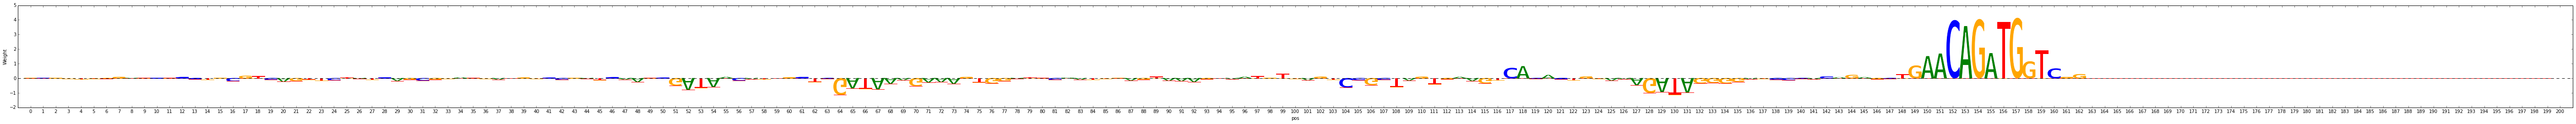

guided_backprop
('Saving', 'task0_sequence_guided_backprop_19643.png')


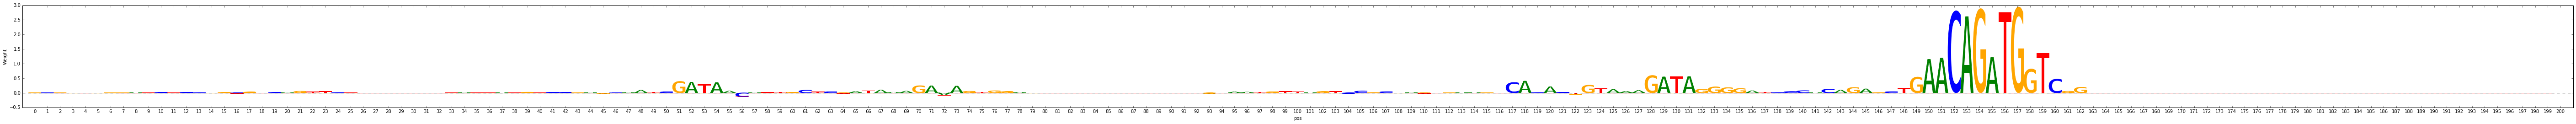

deeplift_contribs
('Saving', 'task0_sequence_deeplift_contribs_19643.png')


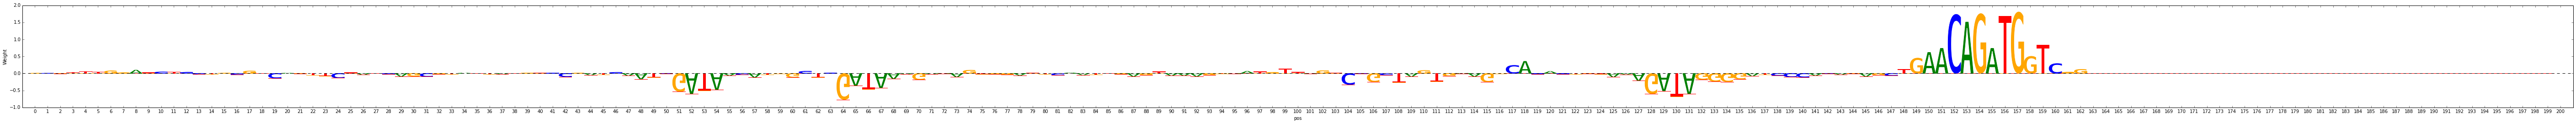

deeplift_expo_upweight_contribs
('Saving', 'task0_sequence_deeplift_expo_upweight_contribs_19643.png')


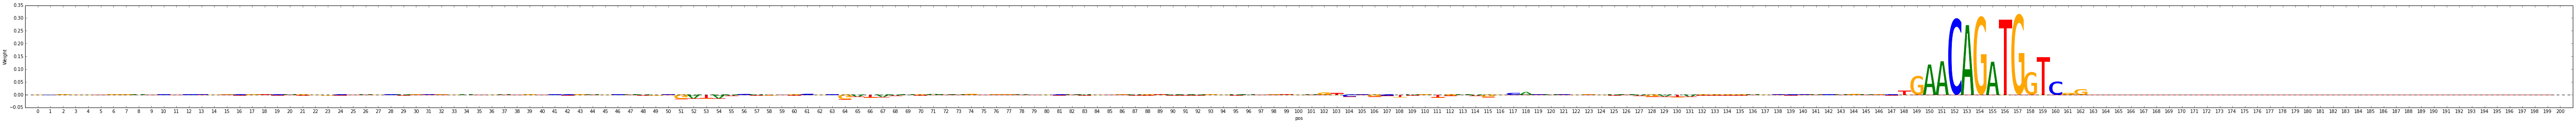

guided_backprop_deeplift1
('Saving', 'task0_sequence_guided_backprop_deeplift1_19643.png')


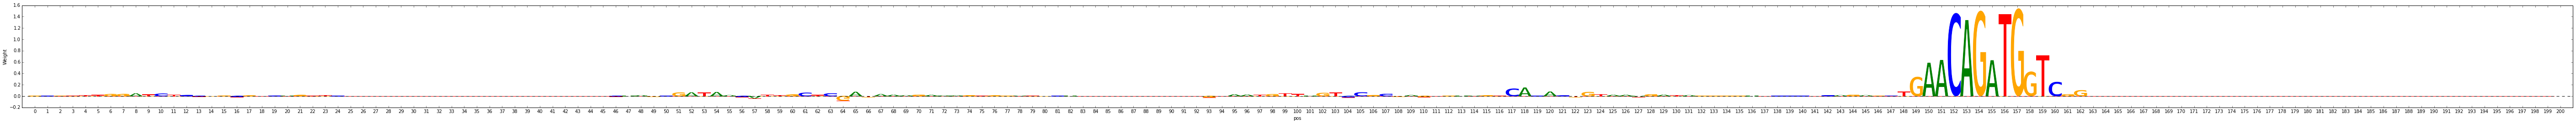

guided_backprop_deeplift4
('Saving', 'task0_sequence_guided_backprop_deeplift4_19643.png')


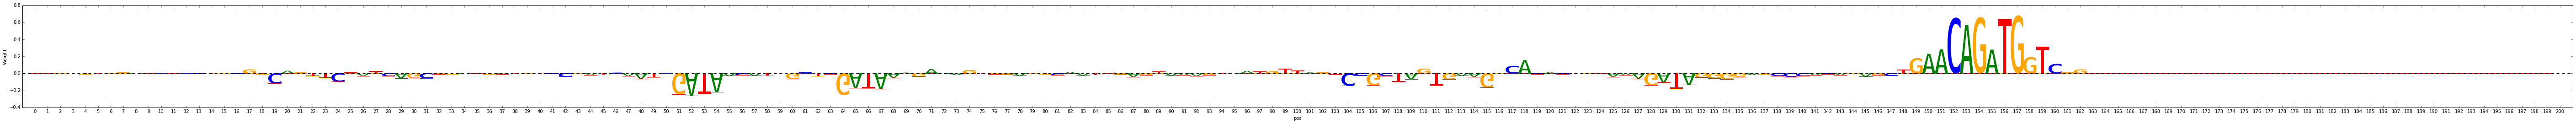

grad_times_inp
('Saving', 'task1_sequence_grad_times_inp_19643.png')


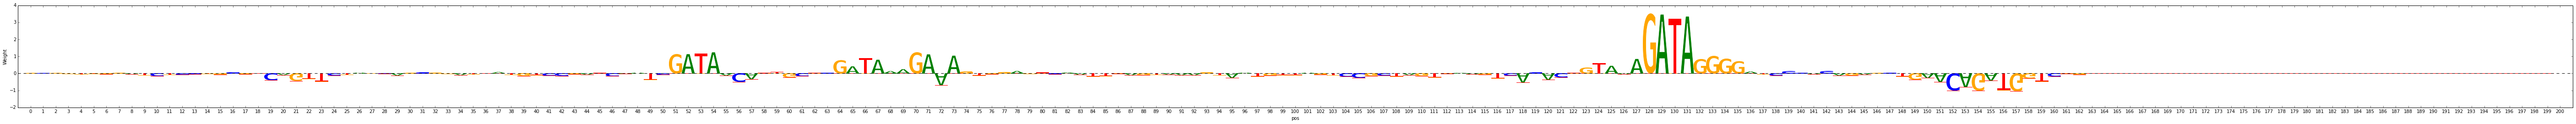

guided_backprop
('Saving', 'task1_sequence_guided_backprop_19643.png')


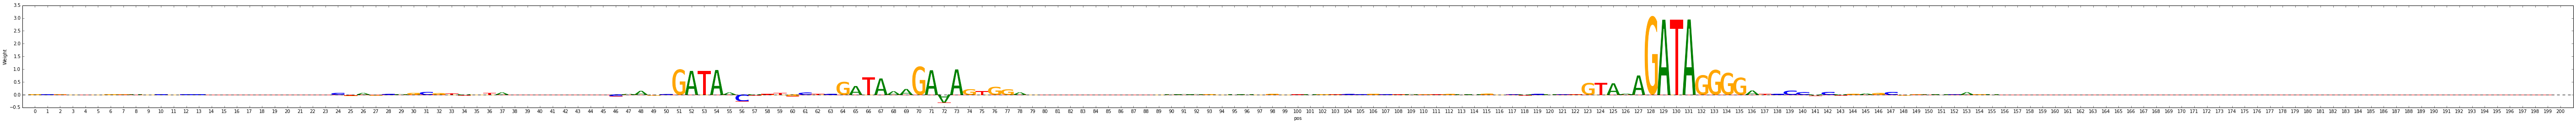

deeplift_contribs
('Saving', 'task1_sequence_deeplift_contribs_19643.png')


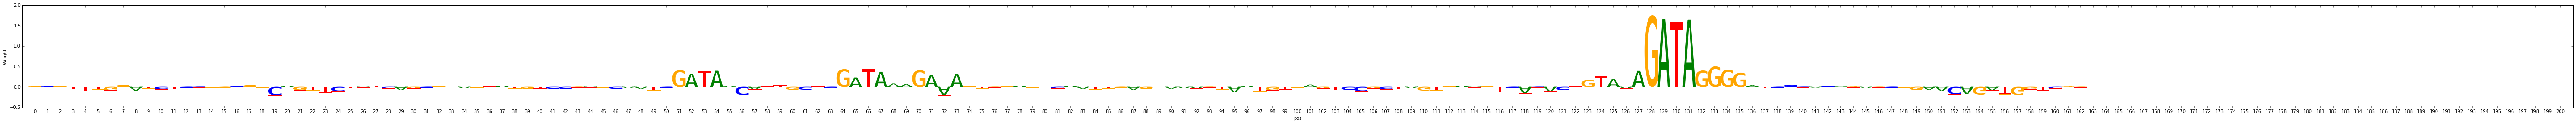

deeplift_expo_upweight_contribs
('Saving', 'task1_sequence_deeplift_expo_upweight_contribs_19643.png')


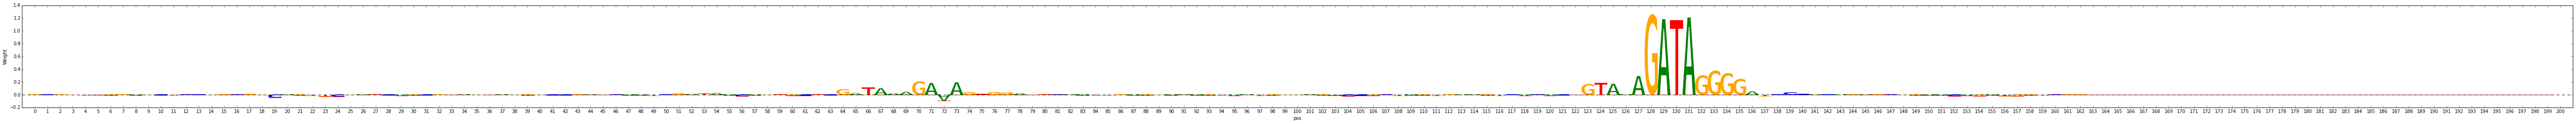

guided_backprop_deeplift1
('Saving', 'task1_sequence_guided_backprop_deeplift1_19643.png')


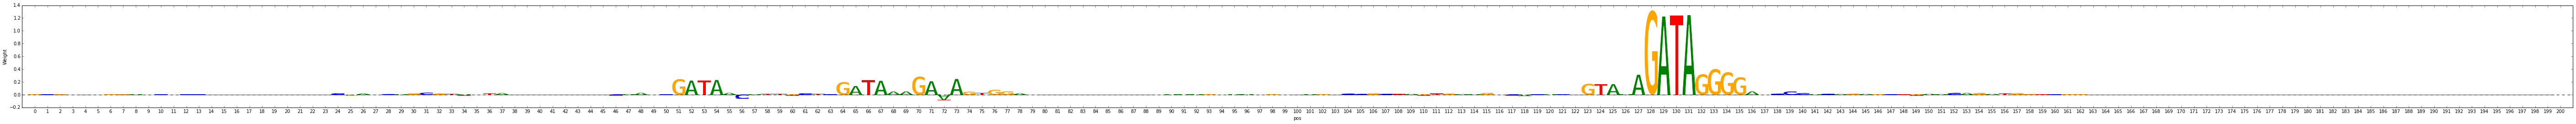

guided_backprop_deeplift4
('Saving', 'task1_sequence_guided_backprop_deeplift4_19643.png')


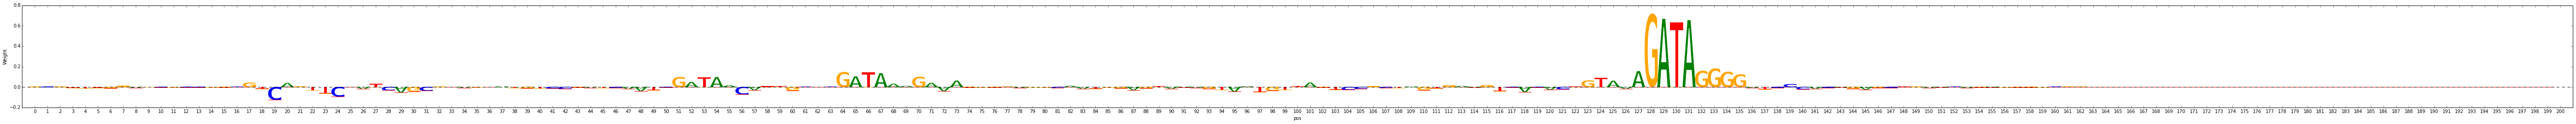

In [ ]:
for task in [0,1,2]:
    for (scores, scores_name) in [
                #(deconv, 'deconv'),
                (grad_times_inp, 'grad_times_inp'),
                (guided_backprop, 'guided_backprop'),
                (deeplift_contribs, 'deeplift_contribs'),
                (deeplift_expo_upweight_contribs, 'deeplift_expo_upweight_contribs'),
                #(deeplift_multipliers, 'deeplift_multipliers'),                                  
                (guided_backprop_deeplift1, 'guided_backprop_deeplift1'),
                (guided_backprop_deeplift4, 'guided_backprop_deeplift4')]:
        print(scores_name)
        makePngOfSequenceDeepLIFTScores(scores[task][0]
                                    , pngName="task"+str(task)+"_sequence_"+scores_name+"_"+str(idx)+".png")

Plot the multipliers for the third task

In [ ]:
makePngOfSequenceDeepLIFTScores(deeplift_multipliers[2][0]
                                    , pngName="task"+str(2)+"_sequence_multipliers_"+str(idx)+".png")